<div style="color:red;background-color:black">
Diamond Light Source

<h1 style="color:red;background-color:antiquewhite"> Python Fundamentals: Curve Fitting</h1>  

©2000-20 Chris Seddon 
</div>

Execute the following cell to activate styling for this tutorial

In [1]:
from IPython.display import HTML
HTML(f"<style>{open('my.css').read()}</style>")

## 1
At Diamond we often need to fit experimental data.  Python offers support with several libraries:
* numpy
* scipy
* matplotlib
* hdf5  

At Diamond, experimental data if often in the form of Nexus files - a number of samples Nexus files are used in this tutorial.  If you want to understand more about the structure of Nexus files, take a look at:  

* <a href="https://manual.nexusformat.org/">User Manual and Reference Documentation</a>

The Nexus files for this tutorial are stored in the "nexus" sub-directory:

In [2]:
%%bash
ls nexus

MoKedge_1_15.nxs
i22-4996.nxs


## 2
Before we start analysing these files, we need to see how to use SciPy to perform curve fitting.  If we generate some sample data and add some noise we can try out fitting a simple polynominal.

Suppose we wish to fit the polynomial:
$$y = ax^2 + bx + c$$
where a, b and c are unknown constants.  
We can create some test data and plot it with the following code:

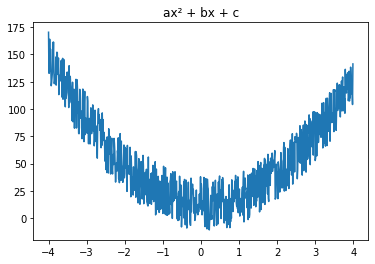

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


ax = plt.gca()
ax.set_title("ax" + chr(0x00B2) + " + bx + c")

x = np.arange(-4, 4, 0.01)
noise = np.random.rand((len(x)))-0.5 # between -0.5 and 0.5
y = 7.8*x**2 - 2.3*x + 13.4 + 50 * noise
plt.plot(x, y)
print()

## 3 
Now we define the function to fit.  The function must have the input variable "x" as the first parameter, followed by all the unknown constants (a, b and c in our case).  The function must return "y".  SciPy will use the experimental data to estimate value for the unknown constants.  

SciPy curve fitting is designed for one dimensional fits.  It is possible to adapt the algorithm to multiple dimensions, but it is not straightford to do so.

Here is our fitting function:

In [4]:
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

## 4
We can perform the fit using SciPy's "curve_fit" method.  The method takes a pointer to our fit function, followed by the "x" and "y" experimental data.  The last parameter is a list of initial guesses for the 3 unknown constants.  If the initial guess is too far off, the fitting will fail.  Usually it's fairly easy to come up with some reasonable estimates.

In [5]:
import scipy.optimize

def initialGuess():    
    a = 5
    b = 0
    c = 8
    return [a, b, c]

fit, estimated_covariance = scipy.optimize.curve_fit(quadratic, x, y, p0=initialGuess())
print(f"estimates of [a, b, c] are {fit}")

estimates of [a, b, c] are [ 7.82482699 -1.9583448  13.24505748]


## 5
The curve fit returns estimates of the unknown constants and the estimated covariance.  The covariance information is discussed in SciPy documentation:
* <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit">scipy.optimize.curve_fit</a>

All that remains it to plot the fit against the experimental data:

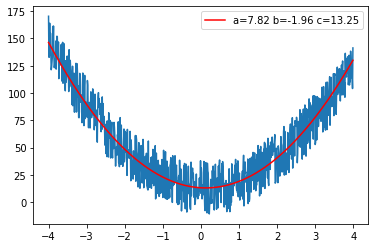

In [6]:
plt.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.plot(x, quadratic(x, *fit), 'r-',
         label=f'a={fit[0]:.2f} b={fit[1]:.2f} c={fit[2]:.2f}')
plt.legend()
plt.show()

## 6
The three constants are reasonably accurate, especially in view of the large noise component.  Reduce the noise and we'd be even more accurate:

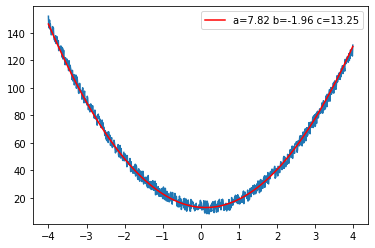

In [7]:
y = 7.8*x**2 - 2.3*x + 13.4 + 10 * noise
plt.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.plot(x, quadratic(x, *fit), 'r-',
         label=f'a={fit[0]:.2f} b={fit[1]:.2f} c={fit[2]:.2f}')
plt.legend()
plt.show()

## 7
We can now turn our attention to Nexus files.  Bear in mind that Diamond have produced the "Dawn" workbench which is based on Eclipse and will automatically draw plots for Nexus files.  What we aim to do here is show how to produce equivalent plota in Jupyter notebook.  

Recall that to run Dawn you need to enter (at the command prompt):
<pre>module load dawn
dawn</pre>

Let's start with the file <pre>data/i22-4996.nxs</pre>
Before we plot anything we need to know what keys are stored in this file.  If you are using Dawn, this information is automatically displayed, but in notebook we need to do a little work.

In [8]:
import os
import h5py

f = h5py.File("nexus/i22-4996.nxs", "r")

for group in f:
    print(f[f"/{group}"])
    for subgroup in f[group]:
        print(f[f"/{group}/{subgroup}"])

<HDF5 group "/entry1" (12 members)>
<HDF5 group "/entry1/Calibration" (1 members)>
<HDF5 group "/entry1/Hotwaxs" (1 members)>
<HDF5 group "/entry1/Rapid2D" (1 members)>
<HDF5 group "/entry1/TfgTimes" (1 members)>
<HDF5 dataset "entry_identifier": shape (1,), type "|S4">
<HDF5 group "/entry1/instrument" (6 members)>
<HDF5 dataset "program_name": shape (1,), type "|S9">
<HDF5 dataset "scan_command": shape (1,), type "|S14">
<HDF5 dataset "scan_dimensions": shape (1,), type "<i4">
<HDF5 dataset "scan_identifier": shape (1,), type "|S36">
<HDF5 dataset "title": shape (1,), type "|S31">
<HDF5 group "/entry1/user01" (1 members)>


## 8
We intend to plot the "Hotwaxs" data, so we need to establish how much data we have and the dimensional information for the data. This is easily achieved using:

In [9]:
import h5py

f = h5py.File("nexus/i22-4996.nxs", "r")

# get dataset
ds = f["/entry1/Hotwaxs/data"]

# check shape (1,1,512)
print(ds.shape)

(1, 1, 512)


## 9
The nexus data needs to be converted to a Numpy array to be plotted.  In the above example the first two dimensions contain *DON'T KNOW* and need to be removed.  This will reduce the data to a one dimensional set which is easily plotted.  

Note that to convert a dataset to a Numpy array the expression
<pre>ds.value[0,0]</pre>
used to be used, but is now deprecated.  Instead we use
<pre>ds[(0,0)]</pre>

dataset shape = (1, 1, 512)


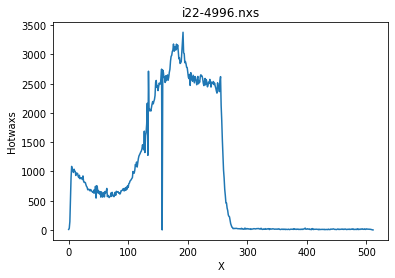

In [10]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt

# open Nexus file
f = h5py.File("nexus/i22-4996.nxs", "r")

# get dataset
ds = f["/entry1/Hotwaxs/data"]

# check shape (1,1,512)
print(f"dataset shape = {ds.shape}")

# extract last dimension to numpy array
X = ds[(0,0)]
size = X.shape[0] 
Y = np.arange(size)

ax = plt.gca()
ax.set_title("i22-4996.nxs")
ax.set_xlabel("X")
ax.set_ylabel("Hotwaxs")
plt.plot(Y, X)
plt.show()

## 10
Now we can plot the data outside Dawn, we can perform additional customised processing as desired.  Say, for example, we wish to apply a filter to the data, we could use SciPy's "savgol" filter:
* <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html">scipy.signal.savgol_filter</a>

dataset shape = (1, 1, 512)


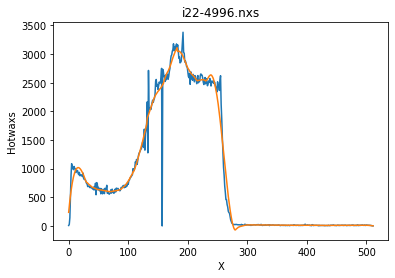

In [11]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


# open Nexus file
f = h5py.File("nexus/i22-4996.nxs", "r")

# get dataset
ds = f["/entry1/Hotwaxs/data"]

# check shape (1,1,512)
print(f"dataset shape = {ds.shape}")

# extract last dimension to numpy array
Y = ds[(0,0)]
size = Y.shape[0] 
X = np.arange(size)
# window size 51, polynomial order 3
Y_filtered = savgol_filter(Y, 51, 3) 


ax = plt.gca()
ax.set_title("i22-4996.nxs")
ax.set_xlabel("X")
ax.set_ylabel("Hotwaxs")
plt.plot(X, Y)
plt.plot(X, Y_filtered)
plt.show()